In [1]:
# encoding=utf8

# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import pickle

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Set de entrenamiento con el target Damage Grade includio
data = pd.read_csv('data/train_values.csv',dtype = {
    "building_id" : "int32",
    "geo_level_1_id" : "int8", 
    "geo_level_2_id" : "int16",
    "geo_level_3_id" : "int16",
    "count_floors_pre_eq" : "int8",
    "age" : "int16",
    "area_percentage" :"int8",
    "height_percentage" :"int8",
    "land_surface_condition" :"category",
    "foundation_type" :"category",
    "roof_type" :"category",
    "ground_floor_type" :"category",
    "other_floor_type" :"category",
    "position" :"category",
    "plan_configuration" :"category",
    "has_superstructure_adobe_mud" : "bool",
    "has_superstructure_mud_mortar_stone" : "bool",
    "has_superstructure_stone_flag" : "bool",
    "has_superstructure_cement_mortar_stone" : "bool",
    "has_superstructure_mud_mortar_brick" : "bool",
    "has_superstructure_cement_mortar_brick" : "bool",
    "has_superstructure_timber" : "bool",
    "has_superstructure_bamboo" : "bool",
    "has_superstructure_rc_non_engineered" : "bool",
    "has_superstructure_rc_engineered" : "bool",
    "has_superstructure_other" : "bool",
    "legal_ownership_status" :"category",
    "count_families" : "int8",
    "has_secondary_use" : "bool",
    "has_secondary_use_agriculture" : "bool",
    "has_secondary_use_hotel" : "bool",
    "has_secondary_use_rental" : "bool",
    "has_secondary_use_institution" : "bool",
    "has_secondary_use_school" : "bool",
    "has_secondary_use_industry" : "bool",
    "has_secondary_use_health_post" : "bool",
    "has_secondary_use_gov_office" : "bool",
    "has_secondary_use_use_police" : "bool",
    "has_secondary_use_other" : "bool"},
    index_col='building_id')

data_labels =  pd.read_csv('data/train_labels.csv',dtype = {"damage_grade" : "int8" },index_col='building_id')
data_labels

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3
...,...
688636,2
669485,3
602512,3


 - Tras los analisis realizados en el proceso de feature engineering, se llego a la conclusion de que las siguientes columnas son las mas importantes:
     - count_floors_per_eq
     - area_percentage
     - foundation_type (r,w,u,i)
     - roof_type (x)
     - other_floor_type(s,q,j)
     - ground_floor_type(f,v)
     - superstructure_mud_mortar_stone
     - superstructure_cement_mortar_brick
     - superstructure_rc_non_engineered
     - superstructure_rc_engineered

In [3]:
features_importantes = ["count_floors_pre_eq",
                        "area_percentage",
                        "has_superstructure_mud_mortar_stone",
                        "has_superstructure_mud_mortar_brick",
                        "has_superstructure_rc_non_engineered",
                        "has_superstructure_rc_engineered"
                        ]

data_train = data[features_importantes]

foundation_dummies = pd.get_dummies(data["foundation_type"])
data_train["foundation_r"] = foundation_dummies["r"]
data_train["foundation_w"] = foundation_dummies["w"]
data_train["foundation_u"] = foundation_dummies["u"]
data_train["foundation_i"] = foundation_dummies["i"]

roof_dummies = pd.get_dummies(data["roof_type"])
data_train["roof_x"] = roof_dummies["x"]


pb_dummies = pd.get_dummies(data["ground_floor_type"])
data_train["ground_floor_f"] = pb_dummies["f"]
data_train["ground_floor_v"] = pb_dummies["v"]

of_dummies = pd.get_dummies(data["other_floor_type"])
data_train["other_floor_s"] = of_dummies["s"]
data_train["other_floor_q"] = of_dummies["q"]
data_train["other_floor_j"] = of_dummies["j"]

data_train

,count_floors_pre_eq,area_percentage,has_superstructure_mud_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,foundation_r,foundation_w,foundation_u,foundation_i,roof_x,ground_floor_f,ground_floor_v,other_floor_s,other_floor_q,other_floor_j
building_id,,,,,,,,,,,,,,,,
802906,2,6,True,False,False,False,1,0,0,0,0,1,0,0,1,0
28830,2,8,True,False,False,False,1,0,0,0,0,0,0,0,1,0
94947,2,5,True,False,False,False,1,0,0,0,0,1,0,0,0,0
590882,2,6,True,False,False,False,1,0,0,0,0,1,0,0,0,0
201944,3,8,False,False,False,False,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,6,True,False,False,False,1,0,0,0,0,1,0,0,0,1
669485,2,6,True,False,False,False,1,0,0,0,0,1,0,0,1,0
602512,3,6,True,False,False,False,1,0,0,0,0,1,0,0,1,0


<AxesSubplot:title={'center':'Number of Buildings with Each Damage Grade'}>

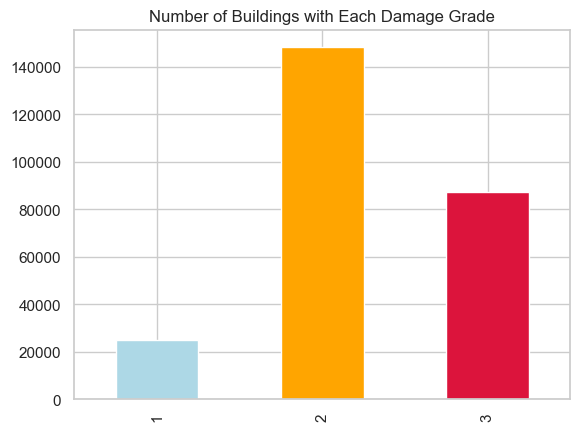

In [4]:
(data_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade",color=["lightblue","orange","crimson"]))

# Modelo Inicial Machine Learning

# Random Forest

Hiperparametros a considerar:
    
    n_estimators: cantidad de árboles a construir (100)
    max_depth: máxima profundidad de cada árbol
    min_samples_split: la cantidad mínima de datos requeridos para splitear un nodo interno (2)
    min_samples_leaf: cantidad mínima de datos requeridos para ser una hoja (1)
    max_features: la cantidad de features a considerar cuando se busca el mejor split (n)

In [4]:
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [5]:
param_grid = {'randomforestclassifier__n_estimators': [50, 200],
              'randomforestclassifier__min_samples_leaf': [1, 5],
              'randomforestclassifier__max_depth': [1, 5],
              'randomforestclassifier__min_samples_split': [1, 5],
              'randomforestclassifier__max_features': [1, 16],
             }
gs = GridSearchCV(pipe, param_grid, cv=5)

In [6]:
gs.fit(data_train, data_labels.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2018))]),
             param_grid={'randomforestclassifier__max_depth': [1, 5],
                         'randomforestclassifier__max_features': [1, 16],
                         'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__min_samples_split': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 200]})

In [7]:
gs.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_features': 16,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 200}

In [8]:
in_sample_preds = gs.predict(data_train)
f1_score(data_labels, in_sample_preds, average='micro')

0.580308594364565

## Prediccion

In [9]:
#Set de Test
test_values = pd.read_csv('data/test_values.csv',dtype = {
    "building_id" : "int32",
    "geo_level_1_id" : "int8", 
    "geo_level_2_id" : "int16",
    "geo_level_3_id" : "int16",
    "count_floors_pre_eq" : "int8",
    "age" : "int16",
    "area_percentage" :"int8",
    "height_percentage" :"int8",
    "land_surface_condition" :"category",
    "foundation_type" :"category",
    "roof_type" :"category",
    "ground_floor_type" :"category",
    "other_floor_type" :"category",
    "position" :"category",
    "plan_configuration" :"category",
    "has_superstructure_adobe_mud" : "bool",
    "has_superstructure_mud_mortar_stone" : "bool",
    "has_superstructure_stone_flag" : "bool",
    "has_superstructure_cement_mortar_stone" : "bool",
    "has_superstructure_mud_mortar_brick" : "bool",
    "has_superstructure_cement_mortar_brick" : "bool",
    "has_superstructure_timber" : "bool",
    "has_superstructure_bamboo" : "bool",
    "has_superstructure_rc_non_engineered" : "bool",
    "has_superstructure_rc_engineered" : "bool",
    "has_superstructure_other" : "bool",
    "legal_ownership_status" :"category",
    "count_families" : "int8",
    "has_secondary_use" : "bool",
    "has_secondary_use_agriculture" : "bool",
    "has_secondary_use_hotel" : "bool",
    "has_secondary_use_rental" : "bool",
    "has_secondary_use_institution" : "bool",
    "has_secondary_use_school" : "bool",
    "has_secondary_use_industry" : "bool",
    "has_secondary_use_health_post" : "bool",
    "has_secondary_use_gov_office" : "bool",
    "has_secondary_use_use_police" : "bool",
    "has_secondary_use_other" : "bool"},
     index_col='building_id')

In [10]:
data_test = test_values[features_importantes]

test_foundation_dummies = pd.get_dummies(test_values["foundation_type"])
data_test["foundation_r"] = test_foundation_dummies["r"]
data_test["foundation_w"] = test_foundation_dummies["w"]
data_test["foundation_u"] = test_foundation_dummies["u"]
data_test["foundation_i"] = test_foundation_dummies["i"]

test_roof_dummies = pd.get_dummies(test_values["roof_type"])
data_test["roof_x"] = test_roof_dummies["x"]


test_pb_dummies = pd.get_dummies(test_values["ground_floor_type"])
data_test["ground_floor_f"] = test_pb_dummies["f"]
data_test["ground_floor_v"] = test_pb_dummies["v"]

test_of_dummies = pd.get_dummies(test_values["other_floor_type"])
data_test["other_floor_s"] = test_of_dummies["s"]
data_test["other_floor_q"] = test_of_dummies["q"]
data_test["other_floor_j"] = test_of_dummies["j"]

data_test

,count_floors_pre_eq,area_percentage,has_superstructure_mud_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,foundation_r,foundation_w,foundation_u,foundation_i,roof_x,ground_floor_f,ground_floor_v,other_floor_s,other_floor_q,other_floor_j
building_id,,,,,,,,,,,,,,,,
300051,3,7,True,False,False,False,1,0,0,0,0,1,0,0,1,0
99355,2,13,True,False,False,False,1,0,0,0,0,1,0,0,1,0
890251,2,4,True,False,False,False,1,0,0,0,0,1,0,0,1,0
745817,1,19,False,False,False,False,1,0,0,0,1,0,1,0,0,1
421793,3,8,True,False,False,False,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,3,20,True,False,False,False,1,0,0,0,0,1,0,0,1,0
663567,3,6,True,False,False,False,1,0,0,0,0,1,0,0,1,0
1049160,1,3,True,False,False,False,1,0,0,0,0,1,0,0,0,1


In [11]:
predictions = gs.predict(data_test)
predictions

array([3, 2, 2, ..., 2, 2, 2], dtype=int8)

## Formato de Entrega

In [12]:
submission_format = pd.read_csv('data/submission_format.csv', index_col='building_id')

In [13]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [17]:
my_submission

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,2
...,...
310028,2
663567,3
1049160,2


In [14]:
my_submission.to_csv('first_random_forest_submission.csv')

Obtuvo 5.795

## Repito Proceso pero selecciono todos los features

In [15]:
data_train = data
data_train = pd.get_dummies(data)

data_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,True,True,False,...,0,0,0,0,0,0,0,0,1,0
28830,8,900,2812,2,10,8,7,False,True,False,...,0,0,0,0,0,0,0,0,1,0
94947,21,363,8973,2,10,5,5,False,True,False,...,0,0,0,0,0,0,0,0,1,0
590882,22,418,10694,2,10,6,5,False,True,False,...,0,0,0,0,0,0,0,0,1,0
201944,11,131,1488,3,30,8,9,True,False,False,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,False,True,False,...,0,0,0,1,0,0,0,0,1,0
669485,17,715,2060,2,0,6,5,False,True,False,...,0,0,0,0,0,0,0,0,1,0
602512,17,51,8163,3,55,6,7,False,True,False,...,0,0,0,0,0,0,0,0,1,0


In [16]:
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [17]:
param_grid = {'randomforestclassifier__n_estimators': [50, 1000],
             'randomforestclassifier__max_depth': [1, 5],
              'randomforestclassifier__min_samples_split': [1, 5],}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [18]:
gs.fit(data_train, data_labels.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2018))]),
             param_grid={'randomforestclassifier__max_depth': [1, 5],
                         'randomforestclassifier__min_samples_split': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 1000]})

In [19]:
gs

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2018))]),
             param_grid={'randomforestclassifier__max_depth': [1, 5],
                         'randomforestclassifier__min_samples_split': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 1000]})

In [20]:
gs.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 1000}

In [21]:
in_sample_preds = gs.predict(data_train)
f1_score(data_labels, in_sample_preds, average='micro')

0.5778642445731214

- Para la metrifa micro F1, la prediccion es mejor cuando el numero es mas cercano a 1

In [22]:
data_test = test_values
data_test = pd.get_dummies(test_values)
data_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,False,True,False,...,0,0,0,0,0,0,0,0,1,0
99355,6,141,11987,2,25,13,5,False,True,False,...,0,0,0,0,0,0,0,0,1,0
890251,22,19,10044,2,5,4,5,False,True,False,...,0,0,0,0,0,0,0,0,1,0
745817,26,39,633,1,0,19,3,False,False,False,...,0,0,0,0,0,0,0,0,1,0
421793,17,289,7970,3,15,8,7,False,True,False,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,False,True,False,...,0,0,0,0,0,0,0,0,0,1
663567,10,1407,11907,3,25,6,7,True,True,True,...,0,0,0,0,0,0,0,0,1,0
1049160,22,1136,7712,1,50,3,3,False,True,False,...,0,0,0,0,0,0,0,0,1,0


In [23]:
predictions = gs.predict(data_test)
predictions

array([2, 2, 2, ..., 2, 2, 2], dtype=int8)

In [24]:
submission_format = pd.read_csv('data/submission_format.csv', index_col='building_id')

In [25]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [26]:
my_submission.to_csv('second_random_forest_submission.csv')

Obtuvo 5.765

## Pruebo el mismo modelo pero con otros features

In [30]:
#Set de entrenamiento con el target Damage Grade includio
data = pd.read_csv('data/train_values.csv',dtype = {
    "building_id" : "int32",
    "geo_level_1_id" : "int8", 
    "geo_level_2_id" : "int16",
    "geo_level_3_id" : "int16",
    "count_floors_pre_eq" : "int8",
    "age" : "int16",
    "area_percentage" :"int8",
    "height_percentage" :"int8",
    "land_surface_condition" :"category",
    "foundation_type" :"category",
    "roof_type" :"category",
    "ground_floor_type" :"category",
    "other_floor_type" :"category",
    "position" :"category",
    "plan_configuration" :"category",
    "has_superstructure_adobe_mud" : "bool",
    "has_superstructure_mud_mortar_stone" : "bool",
    "has_superstructure_stone_flag" : "bool",
    "has_superstructure_cement_mortar_stone" : "bool",
    "has_superstructure_mud_mortar_brick" : "bool",
    "has_superstructure_cement_mortar_brick" : "bool",
    "has_superstructure_timber" : "bool",
    "has_superstructure_bamboo" : "bool",
    "has_superstructure_rc_non_engineered" : "bool",
    "has_superstructure_rc_engineered" : "bool",
    "has_superstructure_other" : "bool",
    "legal_ownership_status" :"category",
    "count_families" : "int8",
    "has_secondary_use" : "bool",
    "has_secondary_use_agriculture" : "bool",
    "has_secondary_use_hotel" : "bool",
    "has_secondary_use_rental" : "bool",
    "has_secondary_use_institution" : "bool",
    "has_secondary_use_school" : "bool",
    "has_secondary_use_industry" : "bool",
    "has_secondary_use_health_post" : "bool",
    "has_secondary_use_gov_office" : "bool",
    "has_secondary_use_use_police" : "bool",
    "has_secondary_use_other" : "bool"},
    index_col='building_id')

data_labels =  pd.read_csv('data/train_labels.csv',dtype = {"damage_grade" : "int8" },index_col='building_id')
data_labels

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3
...,...
688636,2
669485,3
602512,3


In [32]:
features_importantes = ["count_floors_pre_eq",
                        "area_percentage",
                        "has_superstructure_mud_mortar_stone",
                        "has_superstructure_mud_mortar_brick",
                        "has_superstructure_rc_non_engineered",
                        "has_superstructure_rc_engineered",
                        "foundation_type",
                        "roof_type",
                        "ground_floor_type",
                        "other_floor_type"
                        ]

In [34]:
data_train= data[features_importantes]
data_train = pd.get_dummies(data_train)
data_train

,count_floors_pre_eq,area_percentage,has_superstructure_mud_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,...,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x
building_id,,,,,,,,,,,,,,,,,,,,,
802906,2,6,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
28830,2,8,True,False,False,False,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
94947,2,5,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
590882,2,6,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
201944,3,8,False,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,6,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
669485,2,6,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
602512,3,6,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


In [35]:
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [36]:
param_grid = {'randomforestclassifier__n_estimators': [50, 200],
              'randomforestclassifier__min_samples_leaf': [1, 5],
              'randomforestclassifier__max_depth': [1, 5],
              'randomforestclassifier__min_samples_split': [1, 5],
              'randomforestclassifier__max_features': [1, 16],
             }
gs = GridSearchCV(pipe, param_grid, cv=5)

In [37]:
gs.fit(data_train, data_labels.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2018))]),
             param_grid={'randomforestclassifier__max_depth': [1, 5],
                         'randomforestclassifier__max_features': [1, 16],
                         'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__min_samples_split': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 200]})

In [38]:
gs.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_features': 16,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 200}

In [39]:
in_sample_preds = gs.predict(data_train)
f1_score(data_labels, in_sample_preds, average='micro')

0.5816785046872421

In [41]:
data_test = test_values[features_importantes]
data_test = pd.get_dummies(data_test)
data_test

,count_floors_pre_eq,area_percentage,has_superstructure_mud_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,...,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x
building_id,,,,,,,,,,,,,,,,,,,,,
300051,3,7,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
99355,2,13,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
890251,2,4,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
745817,1,19,False,False,False,False,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
421793,3,8,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,3,20,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
663567,3,6,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1049160,1,3,True,False,False,False,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0


In [42]:
predictions = gs.predict(data_test)
predictions

array([2, 2, 2, ..., 2, 2, 2], dtype=int8)

In [43]:
submission_format = pd.read_csv('data/submission_format.csv', index_col='building_id')

In [44]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [45]:
my_submission.to_csv('third_random_forest_submission.csv')

Obtuvo 5,802

## Pickle Rick

In [93]:
import pickle
#filename es el nombre que le daremos a nuestro archivo
filename = 'pickles/random_forest_pickle.pkl'
#Con el comando dump y la instrucción wb nos aseguramos de crear y escribir sobre el 
#archivo creado, otra precaución es lo que deseamos guardar en este caso fue el modelo
pickle.dump(gs, open(filename,'wb'))

In [95]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2018))]),
             param_grid={'randomforestclassifier__max_depth': [1, 5],
                         'randomforestclassifier__min_samples_split': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 1000]})